#### import libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from Database import Airbnbs, Airbnb_Details, Prices, Hosts, creating_engine, creating_session, closing_session, db_url, Base

#### Exploration Process

##### read the files using pandas

In [179]:
df_airbnb=pd.read_csv("../Data/Airbnb_Open_Data.csv",  na_values=[''])
df_airbnb.head(2)

/tmp/ipykernel_2461/810795504.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_airbnb=pd.read_csv("../Data/Airbnb_Open_Data.csv",  na_values=[''])


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN


##### pre-process data to send to the Database

In [180]:
#We use regex to avoid special characters and numbers
df_airbnb["NAME"] = df_airbnb["NAME"].str.replace(r'[^a-zA-Z\s]', '', regex=True)
df_airbnb["house_rules"] = df_airbnb["house_rules"].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
df_airbnb["host name"] = df_airbnb["host name"].str.replace(r'[^a-zA-Z\s]', '', regex=True)

#We drop those columns that do not contribute significant value to the code.
df_airbnb.drop(["license", "country", "country code"], axis=1, inplace=True)

#We remove the null values from the host name.
df_airbnb["host name"].fillna("no provided") 

#We only accept positive values for the "minimum nights" column.
df_airbnb["minimum nights"] = df_airbnb["minimum nights"].abs()

df_airbnb.to_csv("import.csv", encoding="utf-8", index=False)

##### Connect to Postgres

In [181]:
# Create the engine and the session
engine = creating_engine()
session = creating_session(engine)

##### Creamos las tablas de Database.py

In [182]:
# Crea la tablas si no existen
Base.metadata.create_all(engine) 

##### Send data to PostgreSQL


In [183]:
# Load data into the database.
table = "raw_data"
df_airbnb.to_sql(table, engine, if_exists="replace", index=False)

# Closing the session
closing_session(session)

In [184]:
df_airbnb.head(2)

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,instant_bookable,...,price,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules
0,1001254,Clean quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,False,...,$966,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way youd like ...
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,False,...,$142,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...


#### What type of data are the variables?

In [185]:
df_airbnb.dtypes

id                                  int64
NAME                               object
host id                             int64
host_identity_verified             object
host name                          object
neighbourhood group                object
neighbourhood                      object
lat                               float64
long                              float64
instant_bookable                   object
cancellation_policy                object
room type                          object
Construction year                 float64
price                              object
service fee                        object
minimum nights                    float64
number of reviews                 float64
last review                        object
reviews per month                 float64
review rate number                float64
calculated host listings count    float64
availability 365                  float64
house_rules                        object
dtype: object

#### How many variables of each data type do we have in the dataset?

In [186]:
(
    df_airbnb
    .dtypes
    .value_counts()
)

object     12
float64     9
int64       2
Name: count, dtype: int64

#### What are the dimesions of the dataset? 

In [187]:
df_airbnb.shape

(102599, 23)

#### Are there explicit null values in the dataset?

In [188]:
df_airbnb.isnull().any()

id                                False
NAME                               True
host id                           False
host_identity_verified             True
host name                          True
neighbourhood group                True
neighbourhood                      True
lat                                True
long                               True
instant_bookable                   True
cancellation_policy                True
room type                         False
Construction year                  True
price                              True
service fee                        True
minimum nights                     True
number of reviews                  True
last review                        True
reviews per month                  True
review rate number                 True
calculated host listings count     True
availability 365                   True
house_rules                        True
dtype: bool

#### If there are observations with null values, how many do we have for each variable?

In [189]:
(
    df_airbnb
    .isnull()
    .sum()
    .sort_values(ascending=False)
)


house_rules                       52131
last review                       15893
reviews per month                 15879
availability 365                    448
minimum nights                      409
host name                           406
review rate number                  326
calculated host listings count      319
host_identity_verified              289
service fee                         273
NAME                                250
price                               247
Construction year                   214
number of reviews                   183
instant_bookable                    105
cancellation_policy                  76
neighbourhood group                  29
neighbourhood                        16
lat                                   8
long                                  8
id                                    0
host id                               0
room type                             0
dtype: int64

#### What is the proportion of null values for each variable?

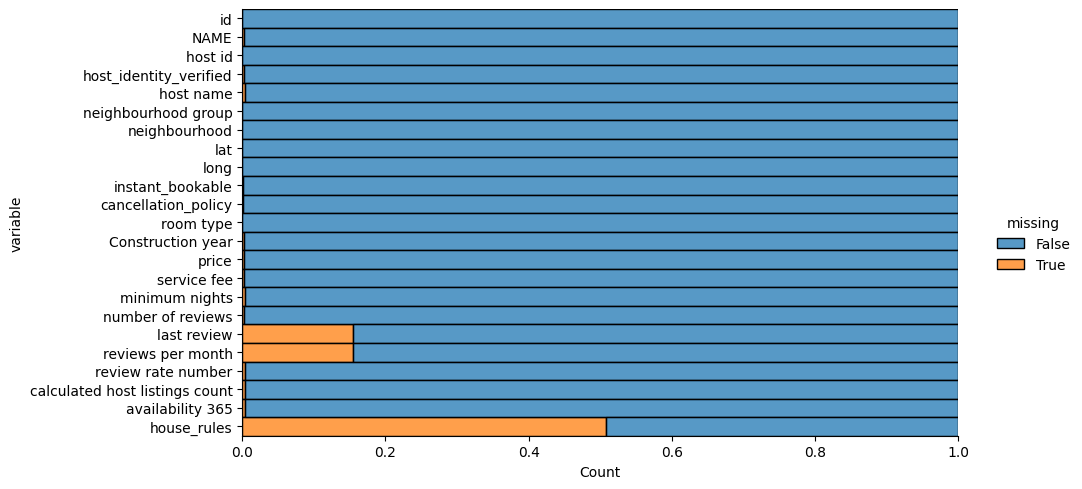

In [190]:
(
    df_airbnb
    .isnull()
    .melt(value_name='missing')
    .pipe(
        lambda df: (
            sns.displot(
                data=df,
                y='variable',
                hue='missing',
                multiple='fill',
                aspect=2
            )
        )
    )
)

#### How many total null values do we have in the dataset?

In [191]:
(
    df_airbnb
    .isnull()
    .sum()
    .sum()
)

87509

## Transform 

#### We standardize the names

In [192]:
new_column_names = [x.lower().replace(" ", "_") for x in df_airbnb.columns]
df_airbnb.columns = new_column_names

#### We remove records that have a repeated ID.

In [193]:
df_airbnb = df_airbnb.drop_duplicates(subset='id', keep='first')

#### We remove records that have a repeated host_id.

In [194]:
df_airbnb = df_airbnb.drop_duplicates(subset='host_id', keep='first')

#### Since the "host_identity_verified" attribute has null values, we are going to fill those values with "unverified".

In [195]:
df_airbnb["host_identity_verified"].fillna("unverified", inplace=True)
df_airbnb.head(2)

,id,name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,lat,long,instant_bookable,...,price,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,house_rules
0,1001254,Clean quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,False,...,$966,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way youd like ...
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,False,...,$142,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...


#### It is neccesaty to delete the '$' symbol from columns price and service_fee

In [196]:
df_airbnb["price"] = df_airbnb["price"].str.replace('$', '').str.replace(',', '').str.strip()
df_airbnb["service_fee"] = df_airbnb["service_fee"].str.replace('$', '').str.replace(',', '').str.strip()

# Convert the "price" and "service_fee" columns to floating-point values.
df_airbnb["price"] = df_airbnb["price"].astype(float)
df_airbnb["service_fee"] = df_airbnb["service_fee"].astype(float)

# We verify that there is no record where the service fee is greater than the price.
counter = df_airbnb["price"] < df_airbnb["service_fee"]
count_greater_service_fee = counter.sum()
count_greater_service_fee

0

#### Clean the non-finite values in the "Construction year" column.

In [197]:
df_airbnb["construction_year"] = df_airbnb["construction_year"].replace([np.inf, -np.inf], np.nan)
df_airbnb["construction_year"] = df_airbnb["construction_year"].fillna(0)  # Rellenar valores nulos con 0 

#### We change the "Construction year" column from type float64 to int32 since years are integers.

In [198]:
df_airbnb["construction_year"] = df_airbnb["construction_year"].astype(int)

#### Replace null values with 0 in the "last review" and "reviews per month" columns when the "number of reviews" column is 0.

In [199]:
filtered_df = df_airbnb[df_airbnb["number_of_reviews"] == 0]
# Show the filtered records.
print(filtered_df)

# Count the null values in the "last_review" column.
null_last_review = filtered_df["last_review"].isnull().sum()
# Count the null values in the "reviews_per_month" column.
null_reviews_per_month = filtered_df["reviews_per_month"].isnull().sum()

              id                                              name  \
2        1002403                    THE VILLAGE OF HARLEMNEW YORK    
20       1012382                  Huge  BR Upper East  Cental Park   
27       1016248  Magnifique Suite au N de Manhattan  vue Cloitres   
37       1021771                       Clean and Quiet in Brooklyn   
39       1022876                         Country space in the city   
...          ...                                               ...   
102035  57355267  rooms in sunny Loft right off the Bedford L stop   
102037  57356371                                      Bx Apartment   
102045  57360790        Private Bedroom in Rego Park  Forest Hills   
102051  57364103                A cozy getaway home away from home   
102056  57366865         Room  private bathroom in historic Harlem   

            host_id host_identity_verified host_name neighbourhood_group  \
2       78829239556             unverified     Elise           Manhattan   
20     

In [200]:
df_airbnb.loc[df_airbnb["number_of_reviews"] == 0, "reviews_per_month"] = 0

#### Replace null values in the "house_rules," "minimum nights," and "instant_bookable" columns.

In [201]:
df_airbnb["house_rules"] = df_airbnb["house_rules"].fillna("No se Especificaron Las Reglas")
df_airbnb["minimum_nights"] = df_airbnb["minimum_nights"].fillna(1)
df_airbnb["instant_bookable"] = df_airbnb["instant_bookable"].fillna(False)

##### Remove the columns related to neighborhoods and coordinates (lat, long).

In [202]:
df_airbnb.drop(["neighbourhood_group","neighbourhood", "lat", "long"], inplace=True, axis="columns")

##### Creation of the "city" column. We will randomly assign values that match the cities from the API.

In [203]:
cities = [
    'New York', 'Harper Woods', 'Huntington Park', 'Oasis Spring', 'Coalville', 'Chicago', 'Seattle', 'Baltimore',
    'Ducktown', 'Mullica Hill', 'Willingboro', 'Middletown', 'Houston', 'Boston', 'San Diego', 'Ravenswood', 'Seaside Heights',
    'Isla Vista', 'Beeville', 'Holderness']
# Add city column based on the city that we extract from the api
df_airbnb["city"] = np.random.randint(1, len(cities) + 1, size=len(df_airbnb))


In [204]:
(
    df_airbnb
    .isnull()
    .sum()
    .sort_values(ascending=False)
)


last_review                       15832
availability_365                    448
host_name                           404
calculated_host_listings_count      319
review_rate_number                  319
service_fee                         273
name                                249
price                               247
number_of_reviews                   183
reviews_per_month                   145
cancellation_policy                  76
house_rules                           0
id                                    0
minimum_nights                        0
construction_year                     0
room_type                             0
instant_bookable                      0
host_identity_verified                0
host_id                               0
city                                  0
dtype: int64

#### Merge with the API

#### Fetch data from the API that will be part of a dimension in the Data Warehouse.

#### Creating Dimensions 

In [205]:
prices_table = pd.read_csv('../Data/df1_API.csv')
prices_table.drop(["Unnamed: 0","usd", "measure", "currency_code"], inplace=True, axis="columns")

prices_table.reset_index(inplace=True)

#### Creating "middle_table" between prices and airbnb_transactions

In [206]:
cities = [
    'New York', 'Harper Woods', 'Huntington Park', 'Oasis Spring', 'Coalville', 'Chicago', 'Seattle', 'Baltimore',
    'Ducktown', 'Mullica Hill', 'Willingboro', 'Middletown', 'Houston', 'Boston', 'San Diego', 'Ravenswood', 'Seaside Heights',
    'Isla Vista', 'Beeville', 'Holderness'
]

id_cities = []
city_names = []

count = 1

for city in cities:
    id_cities.append(count)
    city_names.append(city)
    count += 1 

middle_table = pd.DataFrame({
    'id_city': id_cities,
    'city': city_names
})


In [207]:
host_table = df_airbnb[["host_id", "host_name", "host_identity_verified"]]

,host_id,host_name,host_identity_verified
0,80014485718,Madaline,unconfirmed
1,52335172823,Jenna,verified


In [208]:
airbnb_detail = df_airbnb[
    ["id", "name", "instant_bookable", 
     "cancellation_policy", "room_type", "construction_year", 
    "minimum_nights", "number_of_reviews", 
     "last_review", "reviews_per_month", "review_rate_number", "calculated_host_listings_count", 
     "availability_365", "house_rules"]]

,id,name,instant_bookable,cancellation_policy,room_type,construction_year,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,house_rules
0,1001254,Clean quiet apt home by the park,False,strict,Private room,2020,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way youd like ...
1,1002102,Skylit Midtown Castle,False,moderate,Entire home/apt,2007,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...


### Proceso de limpieza a nuestra tabla de hecho (df_airbnb)

In [209]:
#Delete the following columns since we already set up diferent tables to save all the information related with neighbourhoods and hosts
df_airbnb.drop(
         ["name", "instant_bookable", 
     "cancellation_policy", "room_type", "construction_year", 
     "minimum_nights", "number_of_reviews", 
     "last_review", "reviews_per_month", "review_rate_number", 
     "calculated_host_listings_count", 
     "availability_365", "house_rules", "host_name", 
     "host_identity_verified"], axis=1, inplace=True)

In [210]:
# Creation of id_transaction based on index
df_airbnb.reset_index(inplace=True)
df_airbnb.rename(columns={'index': 'id_transaction', 'id': 'airbnb_id'}, inplace=True)

### Load Proccess

In [212]:
#Creating session
session2 = creating_session(engine)

In [213]:
# Send "prices" data to PG
table = "prices"
prices_table.to_sql(table, engine, if_exists="replace", index=False)

420

In [214]:
# Send "middile_table" data to PG
table = "middle_table"
middle_table.to_sql(table, engine, if_exists="replace", index=False)

20

In [215]:
# Send "fact_table" data to PG
table = "airbnb_transactions"
df_airbnb.to_sql(table, engine, if_exists="replace", index=False)

57

In [216]:
# Send "hosts" data to PG
table = "hosts"
host_table.to_sql(table, engine, if_exists="replace", index=False)

57

In [217]:
# # Send "airbnbb_detail" data to PG
table = "airbnb_detail"
airbnb_detail.to_sql(table, engine, if_exists="replace", index=False)

57

In [218]:
# Close the session
closing_session(session2)